In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Loading the datasets
fatality_data = pd.read_csv('BITRE_Fatality_5_55052_A_W.csv')
crash_data = pd.read_csv('BITRE_Fatal_Crash_5_49624_A_T.csv')

# Displaying the first few rows of each dataset
fatality_data_head = fatality_data.head()
crash_data_head = crash_data.head()

fatality_data_head, crash_data_head


/tmp/ipykernel_17191/452674687.py:6: DtypeWarning: Columns (14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  fatality_data = pd.read_csv('BITRE_Fatality_5_55052_A_W.csv')
/tmp/ipykernel_17191/452674687.py:7: DtypeWarning: Columns (12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_data = pd.read_csv('BITRE_Fatal_Crash_5_49624_A_T.csv')


(   Crash ID State  Month  Year    Dayweek      Time Crash Type  \
 0  20231101   NSW      7  2023  Wednesday  09:45:00     Single   
 1  20232051   Vic      7  2023    Tuesday  19:40:00     Single   
 2  20236012   Tas      7  2023     Sunday  20:42:00     Single   
 3  20231131   NSW      7  2023     Friday  18:00:00   Multiple   
 4  20235001    WA      7  2023   Saturday  00:02:00     Single   
 
   Bus Involvement Heavy Rigid Truck Involvement Articulated Truck Involvement  \
 0              No                            No                            No   
 1              -9                            -9                            -9   
 2              No                            No                            No   
 3              No                            No                            No   
 4              No                            No                            No   
 
    ...  Age  National Remoteness Areas                 SA4 Name 2021  \
 0  ...   38   Inner Regional

In [15]:
# Merging the datasets on the "Crash ID"
merged_data = pd.merge(fatality_data, crash_data, on="Crash ID", how="inner", suffixes=('_fatality', '_crash'))

# For columns that have the same name in both datasets, prioritize non -9 values
for column in merged_data.columns:
    if column.endswith('_fatality') and column.replace('_fatality', '_crash') in merged_data.columns:
        fatality_col = column
        crash_col = column.replace('_fatality', '_crash')
        
        # Update values where fatality column is -9 with values from crash column
        mask = merged_data[fatality_col] == '-9'
        merged_data.loc[mask, fatality_col] = merged_data.loc[mask, crash_col]
        
        # Drop the redundant crash column
        merged_data.drop(crash_col, axis=1, inplace=True)
        
        # Rename fatality column to original column name
        merged_data.rename(columns={fatality_col: column.replace('_fatality', '')}, inplace=True)


# Keeping casing consistent
for column in merged_data.select_dtypes(include=['object']).columns:
    merged_data[column] = merged_data[column].str.title()


# Filtering out data from before 5 years ago
current_year = 2023
merged_data = merged_data[merged_data['Year'] >= current_year - 5]

# Including only ages 13-18
merged_data = merged_data[(merged_data['Age'] >= 13) & (merged_data['Age'] <= 18)]

# Removing the age group column (if it exists)
if 'Age Group' in merged_data.columns:
    merged_data.drop('Age Group', axis=1, inplace=True)


# Displaying the first few rows of the merged dataset
merged_data_head = merged_data.head()
merged_data_head


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Day of week,Time of day,Number Fatalities,Bus \nInvolvement,Time of Day
2,20236012,Tas,7,2023,Sunday,20:42:00,Single,No,No,No,...,Hobart,Derwent Valley,National Or State Highway,No,No,Weekend,Night,1,No,Night
3,20231131,Nsw,7,2023,Friday,18:00:00,Multiple,No,No,No,...,Newcastle And Lake Macquarie,Lake Macquarie,Arterial Road,No,No,Weekend,Night,1,No,Night
5,20233130,Qld,7,2023,Sunday,23:00:00,Single,No,No,No,...,Brisbane - East,Brisbane,Sub-Arterial Road,No,No,Weekend,Night,1,No,Night
7,20233136,Qld,7,2023,Sunday,18:00:00,Single,No,No,No,...,Brisbane - West,Brisbane,Collector Road,No,No,Weekend,Night,1,No,Night
13,20233095,Qld,7,2023,Friday,00:00:00,Multiple,No,No,No,...,Toowoomba,Toowoomba,Local Road,No,No,Weekday,Night,1,No,Night


In [16]:
# Segmenting the data into NSW and non-NSW
nsw_data = merged_data[merged_data['State'] == 'Nsw']
non_nsw_data = merged_data[merged_data['State'] != 'Nsw']

# Calculating percentage deaths
total_deaths = len(merged_data)
nsw_deaths = len(nsw_data)
non_nsw_deaths = len(non_nsw_data)

nsw_death_percentage = (nsw_deaths / total_deaths) * 100
non_nsw_death_percentage = (non_nsw_deaths / total_deaths) * 100

nsw_death_percentage, non_nsw_death_percentage


(29.04761904761905, 70.95238095238095)

In [17]:
# Function to calculate percentage distribution excluding -9 values
def calculate_percentage_distribution(data, column):
    valid_data = data[data[column] != '-9']
    return (valid_data[column].value_counts(normalize=True) * 100)

# Time Analysis for NSW
time_of_day_counts_nsw = calculate_percentage_distribution(nsw_data, 'Time of Day')
day_of_week_counts_nsw = calculate_percentage_distribution(nsw_data, 'Day of week')
month_counts_nsw = calculate_percentage_distribution(nsw_data, 'Month')

# Road Type and Crash Type Analysis for NSW
road_type_counts_nsw = calculate_percentage_distribution(nsw_data, 'National Road Type')
crash_type_counts_nsw = calculate_percentage_distribution(nsw_data, 'Crash Type')

# Time Analysis for non-NSW
time_of_day_counts_non_nsw = calculate_percentage_distribution(non_nsw_data, 'Time of Day')
day_of_week_counts_non_nsw = calculate_percentage_distribution(non_nsw_data, 'Day of week')
month_counts_non_nsw = calculate_percentage_distribution(non_nsw_data, 'Month')

# Road Type and Crash Type Analysis for non-NSW
road_type_counts_non_nsw = calculate_percentage_distribution(non_nsw_data, 'National Road Type')
crash_type_counts_non_nsw = calculate_percentage_distribution(non_nsw_data, 'Crash Type')

time_of_day_counts_nsw, day_of_week_counts_nsw, month_counts_nsw, road_type_counts_nsw, crash_type_counts_nsw, time_of_day_counts_non_nsw, day_of_week_counts_non_nsw, month_counts_non_nsw, road_type_counts_non_nsw, crash_type_counts_non_nsw


(Time of Day
 Night    50.819672
 Day      49.180328
 Name: proportion, dtype: float64,
 Day of week
 Weekend    52.459016
 Weekday    47.540984
 Name: proportion, dtype: float64,
 Month
 12    11.475410
 9     10.655738
 4      9.016393
 2      9.016393
 3      9.016393
 10     8.196721
 7      8.196721
 6      8.196721
 1      8.196721
 11     6.557377
 5      5.737705
 8      5.737705
 Name: proportion, dtype: float64,
 National Road Type
 Local Road                   29.508197
 Arterial Road                27.049180
 National Or State Highway    15.573770
 Sub-Arterial Road            14.754098
 Collector Road               13.114754
 Name: proportion, dtype: float64,
 Crash Type
 Single      67.213115
 Multiple    32.786885
 Name: proportion, dtype: float64,
 Time of Day
 Night    58.389262
 Day      41.610738
 Name: proportion, dtype: float64,
 Day of week
 Weekend    52.348993
 Weekday    47.651007
 Name: proportion, dtype: float64,
 Month
 7     10.738255
 5     10.738255
 6   

In [18]:
# Function to compare percentage distribution between NSW and non-NSW for a given column
def compare_distributions(column):
    nsw_distribution = calculate_percentage_distribution(nsw_data, column)
    non_nsw_distribution = calculate_percentage_distribution(non_nsw_data, column)
    return nsw_distribution, non_nsw_distribution

# Variables of interest
variables = ['Bus Involvement', 'Heavy Rigid Truck Involvement', 'Articulated Truck Involvement', 
             'Speed Limit', 'National Remoteness Areas']

# Storing the distributions
distributions = {}

# Calculate distributions for each variable
for var in variables:
    distributions[var] = compare_distributions(var)

distributions


{'Bus Involvement': (Bus Involvement
  No     98.360656
  Yes     1.639344
  Name: proportion, dtype: float64,
  Bus Involvement
  No     98.986486
  Yes     1.013514
  Name: proportion, dtype: float64),
 'Heavy Rigid Truck Involvement': (Heavy Rigid Truck Involvement
  No     94.262295
  Yes     5.737705
  Name: proportion, dtype: float64,
  Heavy Rigid Truck Involvement
  No     94.594595
  Yes     5.405405
  Name: proportion, dtype: float64),
 'Articulated Truck Involvement': (Articulated Truck Involvement
  No     96.721311
  Yes     3.278689
  Name: proportion, dtype: float64,
  Articulated Truck Involvement
  No     94.932432
  Yes     5.067568
  Name: proportion, dtype: float64),
 'Speed Limit': (Speed Limit
  100    36.885246
  60     18.032787
  50     18.032787
  80     14.754098
  70      5.737705
  110     4.918033
  40      1.639344
  Name: proportion, dtype: float64,
  Speed Limit
   100    30.536913
   60     17.449664
   80     14.765101
   110    14.093960
   50      9

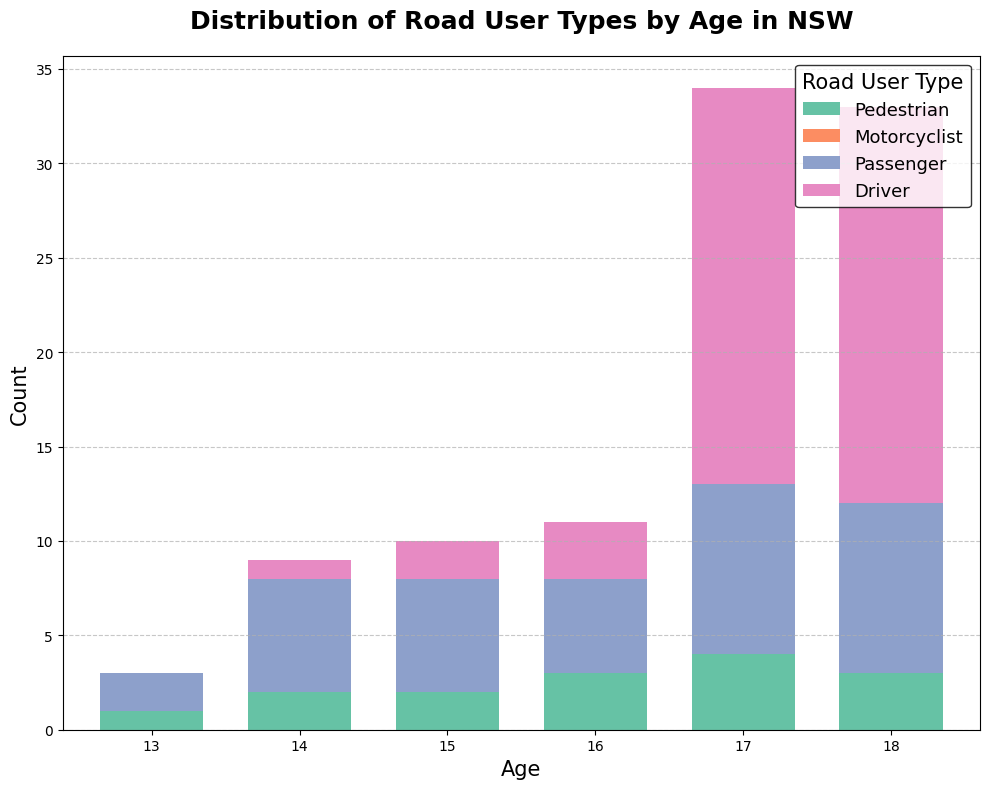

In [29]:
age_groups = [13, 14, 15, 16, 17, 18]
road_user_types = ['Pedestrian', 'Motorcyclist', 'Passenger', 'Driver']

# Calculate the counts for each age and road user type for both NSW and non-NSW
nsw_counts = nsw_data.groupby('Age')['Road User'].value_counts().unstack().reindex(columns=road_user_types).fillna(0)
non_nsw_counts = non_nsw_data.groupby('Age')['Road User'].value_counts().unstack().reindex(columns=road_user_types).fillna(0)
# Plotting just for NSW with the selected color palette
fig, ax = plt.subplots(figsize=(10, 8))

nsw_counts.loc[age_groups].plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.7)

# Setting titles, labels, and legend
ax.set_title('Distribution of Road User Types by Age in NSW', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.legend(title='Road User Type', title_fontsize='15', fontsize='13', loc='upper right', frameon=True, edgecolor='black')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticklabels(age_groups, rotation=0)

plt.tight_layout()
plt.show()



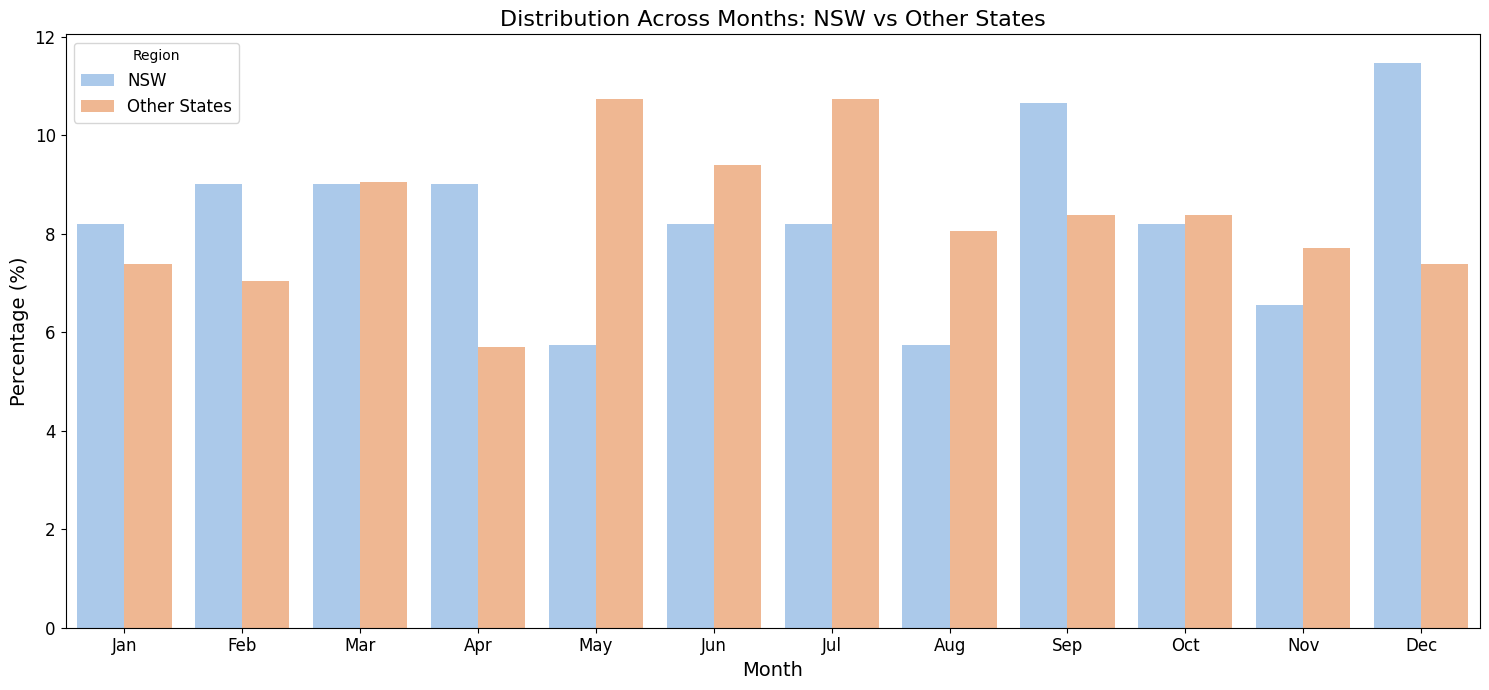

In [19]:
# Combine the two bar plots into a single plot for direct comparison

# Create a DataFrame for easier plotting
combined_data = pd.DataFrame({
    'Month': range(1, 13),
    'NSW': month_counts_nsw.reindex(range(1, 13)).fillna(0),
    'Other States': month_counts_non_nsw.reindex(range(1, 13)).fillna(0)
})

# Melt the DataFrame to a long format suitable for seaborn
melted_data = combined_data.melt(id_vars='Month', var_name='Region', value_name='Percentage')

plt.figure(figsize=(15, 7))
sns.barplot(data=melted_data, x='Month', y='Percentage', hue='Region', palette="pastel")
plt.title("Distribution Across Months: NSW vs Other States", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Region", fontsize=12)
plt.tight_layout()
plt.show()


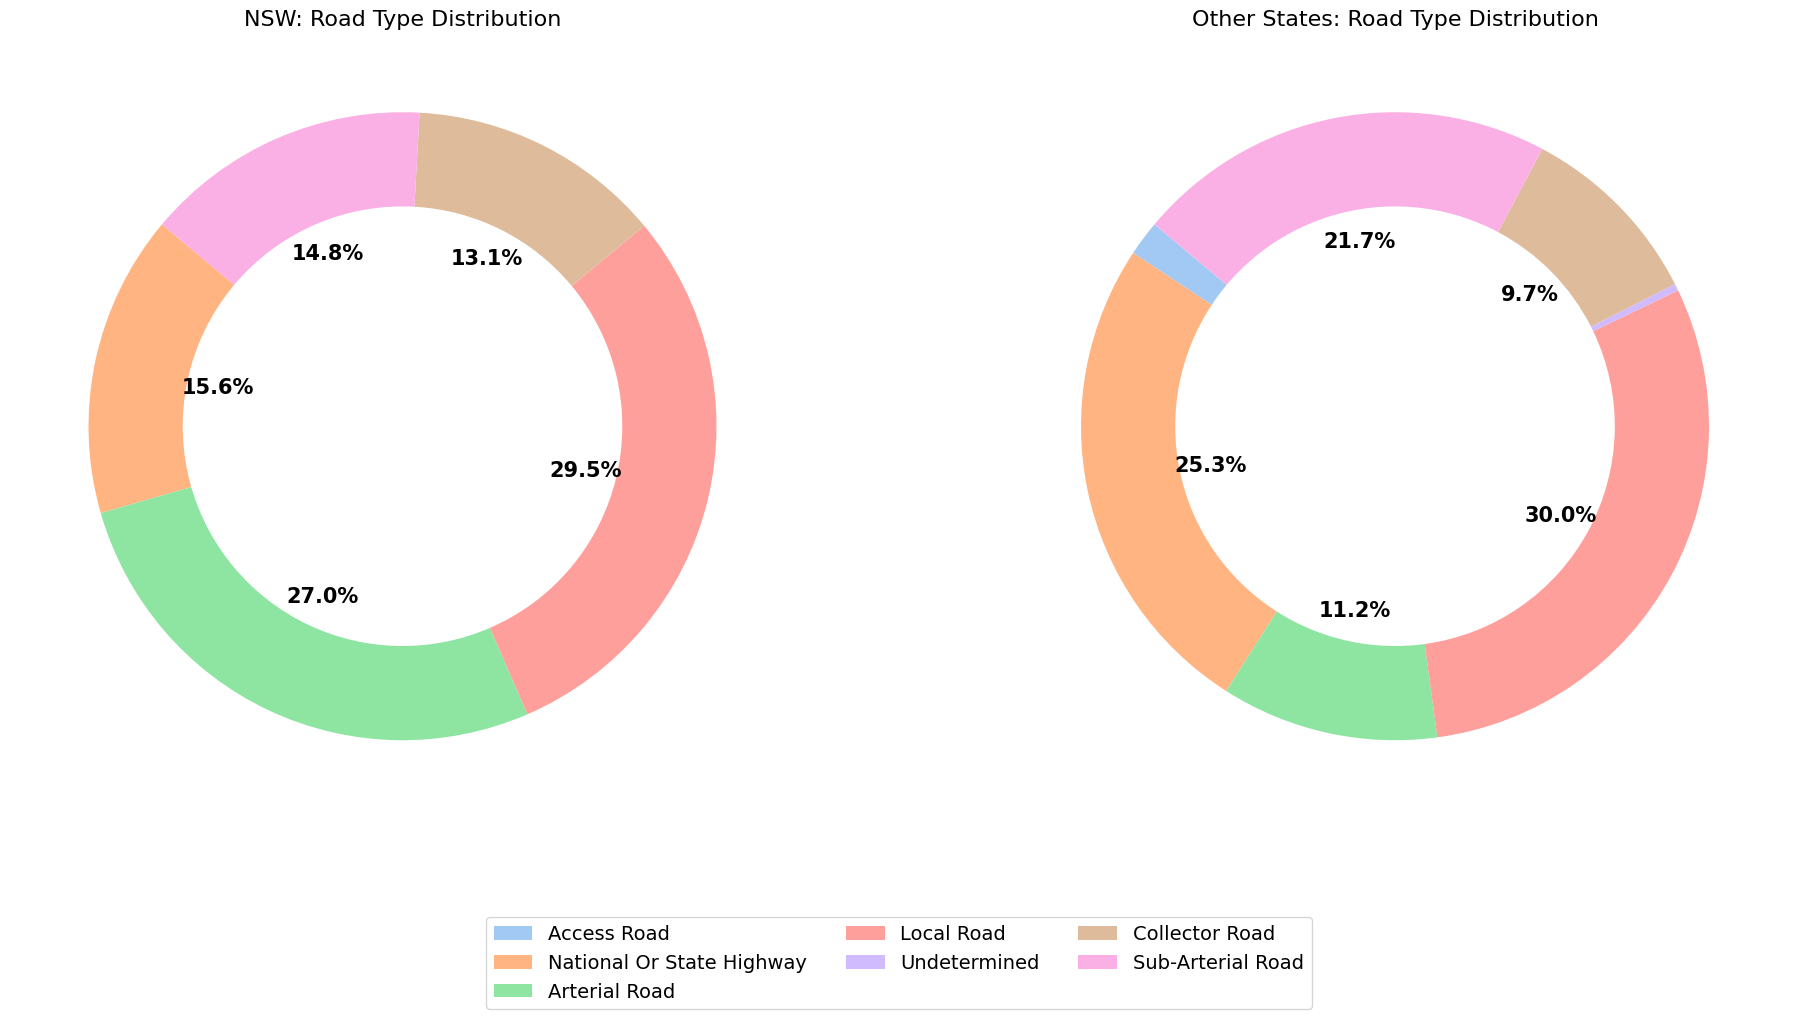

In [24]:
# Reorder road type counts based on the combined set of road types
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    if pct < 2: # threshold to not display small percentages
        return ""
    return "{:.1f}%".format(pct)

unique_road_types = list(set(road_type_counts_nsw.index) | set(road_type_counts_non_nsw.index))
colors = sns.color_palette("pastel", n_colors=len(unique_road_types))
color_mapping = {road_type: color for road_type, color in zip(unique_road_types, colors)}

# Extract colors for each segment in NSW and non-NSW data
colors_nsw = [color_mapping[road_type] for road_type in road_type_counts_nsw.index]
colors_non_nsw = [color_mapping[road_type] for road_type in road_type_counts_non_nsw.index]

ordered_road_type_counts_nsw = road_type_counts_nsw.reindex(unique_road_types).fillna(0)
ordered_road_type_counts_non_nsw = road_type_counts_non_nsw.reindex(unique_road_types).fillna(0)

# Extract colors for each segment based on the consistent order
ordered_colors_nsw = [color_mapping[road_type] for road_type in ordered_road_type_counts_nsw.index]
ordered_colors_non_nsw = [color_mapping[road_type] for road_type in ordered_road_type_counts_non_nsw.index]


# Adjusting the pie charts with larger text and legend

# Create a larger figure to accommodate the charts and the larger legend
plt.figure(figsize=(20, 10))

# Plot for NSW with increased title font size
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(ordered_road_type_counts_nsw, labels=None, colors=ordered_colors_nsw, autopct=lambda pct: func(pct, ordered_road_type_counts_nsw), startangle=140, wedgeprops=dict(width=0.3))
plt.title("NSW: Road Type Distribution", fontsize=16)

# Adjust autotext size for better readability
plt.setp(autotexts, size=15, weight="bold", ha='center')

# Plot for non-NSW with increased title font size
plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(ordered_road_type_counts_non_nsw, labels=None, colors=ordered_colors_non_nsw, autopct=lambda pct: func(pct, ordered_road_type_counts_non_nsw), startangle=140, wedgeprops=dict(width=0.3))
plt.title("Other States: Road Type Distribution", fontsize=16)

# Adjust autotext size for better readability
plt.setp(autotexts, size=15, weight="bold", ha='center')

# Add a shared legend for both pie charts with increased font size
plt.figlegend(wedges, ordered_road_type_counts_nsw.index, loc="lower center", ncol=3, bbox_to_anchor=(0.5, 0), prop={'size': 14})

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


In [23]:
# Segmenting the data based on National Remoteness Areas


# NSW data segmentation
nsw_metro_data = nsw_data[nsw_data['National Remoteness Areas'] == 'Major Cities of Australia']
nsw_rural_data = nsw_data[nsw_data['National Remoteness Areas'].isin(['Inner Regional Australia', 'Outer Regional Australia'])]

# Other states data segmentation
non_nsw_metro_data = non_nsw_data[non_nsw_data['National Remoteness Areas'] == 'Major Cities of Australia']
non_nsw_rural_data = non_nsw_data[non_nsw_data['National Remoteness Areas'].isin(['Inner Regional Australia', 'Outer Regional Australia'])]

# Function to compare percentage distribution between Metro and Rural for a given column
def compare_metro_vs_rural(column):
    nsw_metro_distribution = calculate_percentage_distribution(nsw_metro_data, column)
    nsw_rural_distribution = calculate_percentage_distribution(nsw_rural_data, column)
    
    non_nsw_metro_distribution = calculate_percentage_distribution(non_nsw_metro_data, column)
    non_nsw_rural_distribution = calculate_percentage_distribution(non_nsw_rural_data, column)
    
    return nsw_metro_distribution, nsw_rural_distribution, non_nsw_metro_distribution, non_nsw_rural_distribution

# Variables of interest
variables += ['Time of Day', 'Day of week', 'Crash Type']

# Storing the distributions
metro_vs_rural_distributions = {}

# Calculate distributions for each variable
for var in variables:
    metro_vs_rural_distributions[var] = compare_metro_vs_rural(var)

metro_vs_rural_distributions


{'Bus Involvement': (Series([], Name: proportion, dtype: float64),
  Bus Involvement
  No     98.734177
  Yes     1.265823
  Name: proportion, dtype: float64,
  Series([], Name: proportion, dtype: float64),
  Bus Involvement
  No     98.125
  Yes     1.875
  Name: proportion, dtype: float64),
 'Heavy Rigid Truck Involvement': (Series([], Name: proportion, dtype: float64),
  Heavy Rigid Truck Involvement
  No     94.936709
  Yes     5.063291
  Name: proportion, dtype: float64,
  Series([], Name: proportion, dtype: float64),
  Heavy Rigid Truck Involvement
  No     92.5
  Yes     7.5
  Name: proportion, dtype: float64),
 'Articulated Truck Involvement': (Series([], Name: proportion, dtype: float64),
  Articulated Truck Involvement
  No     94.936709
  Yes     5.063291
  Name: proportion, dtype: float64,
  Series([], Name: proportion, dtype: float64),
  Articulated Truck Involvement
  No     91.875
  Yes     8.125
  Name: proportion, dtype: float64),
 'Speed Limit': (Series([], Name: prop

/tmp/ipykernel_15357/1139728119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data['Hour'] = nsw_data['Time'].str.split(":").str[0].astype(int)
/tmp/ipykernel_15357/1139728119.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nsw_data['Hour'] = non_nsw_data['Time'].str.split(":").str[0].astype(int)


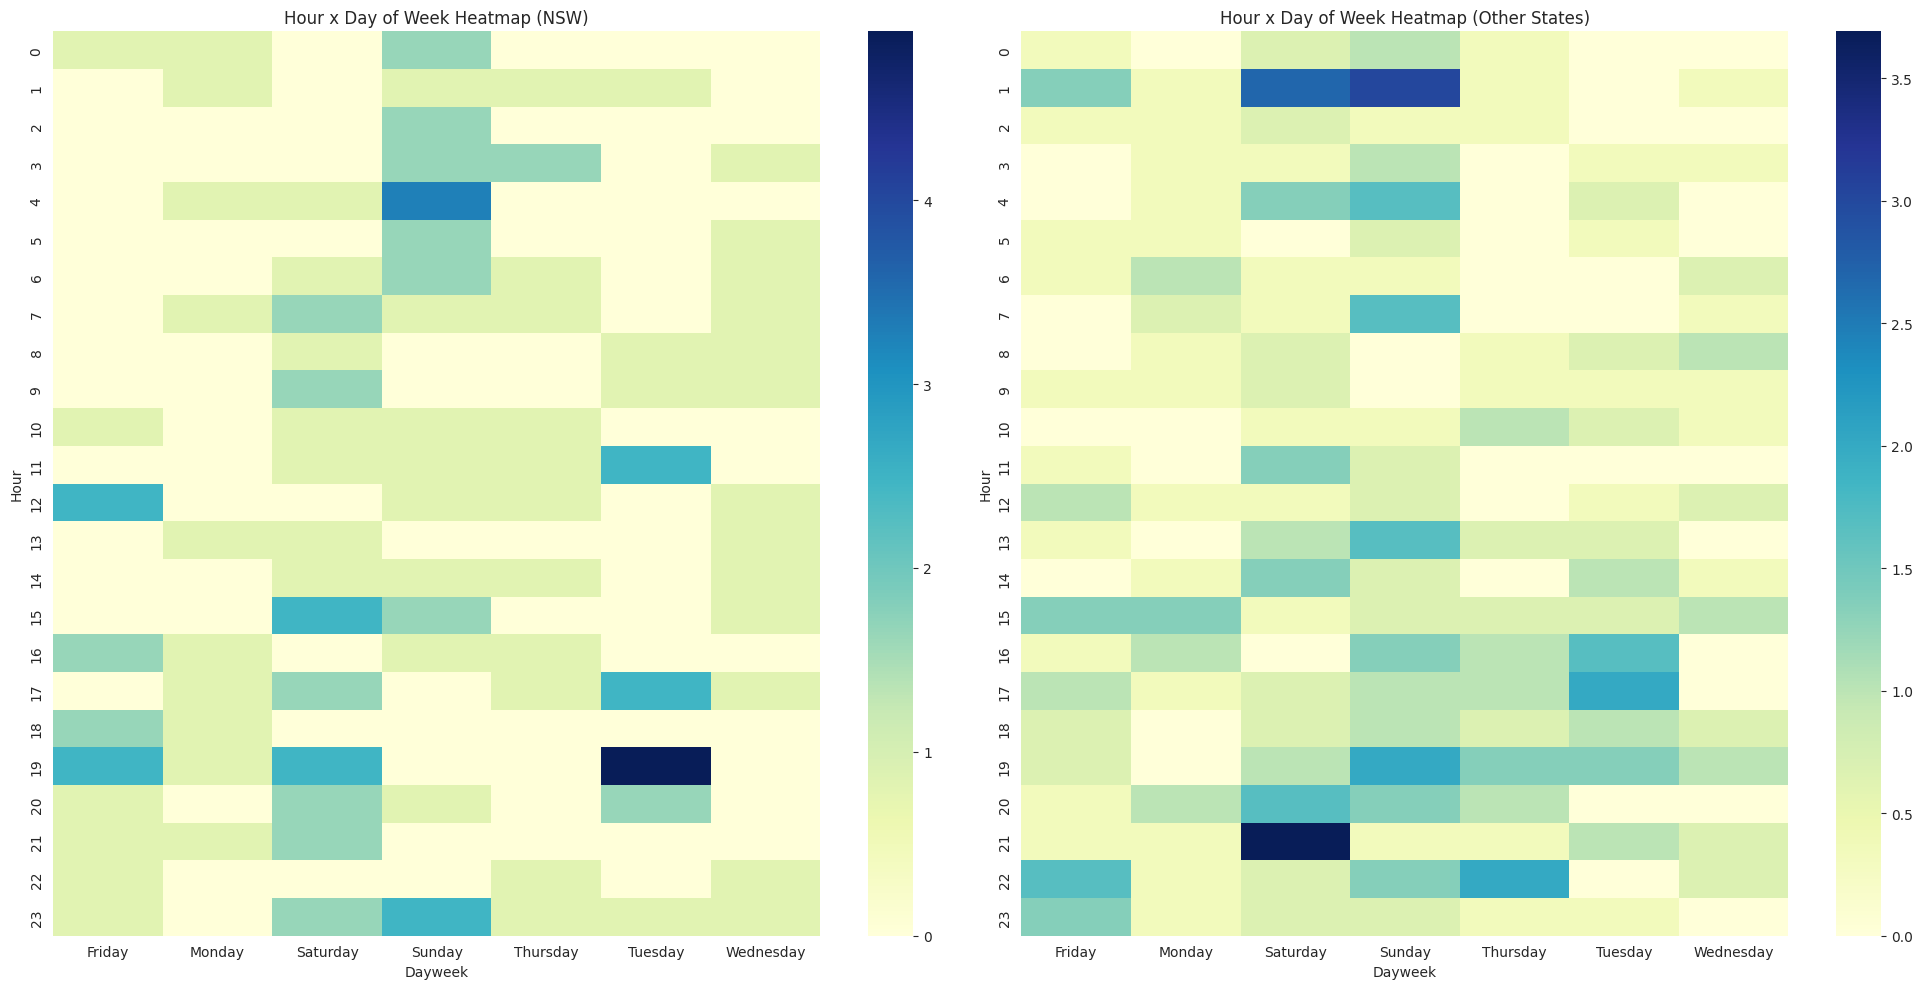

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hour x Day of Week Heatmap

# Grouping the data by 'Hour' and 'Day of week' for NSW
nsw_data['Hour'] = nsw_data['Time'].str.split(":").str[0].astype(int)

hour_day_nsw = nsw_data.groupby(['Hour', 'Dayweek']).size().unstack().fillna(0)
hour_day_nsw_percentage = (hour_day_nsw / hour_day_nsw.sum().sum()) * 100

# Grouping the data by 'Hour' and 'Day of week' for other states

non_nsw_data['Hour'] = non_nsw_data['Time'].str.split(":").str[0].astype(int)

hour_day_non_nsw = non_nsw_data.groupby(['Hour', 'Dayweek']).size().unstack().fillna(0)
hour_day_non_nsw_percentage = (hour_day_non_nsw / hour_day_non_nsw.sum().sum()) * 100

# Creating heatmaps
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(hour_day_nsw_percentage, cmap='YlGnBu', ax=ax[0])
ax[0].set_title('Hour x Day of Week Heatmap (NSW)')

sns.heatmap(hour_day_non_nsw_percentage, cmap='YlGnBu', ax=ax[1])
ax[1].set_title('Hour x Day of Week Heatmap (Other States)')

plt.tight_layout()
plt.show()


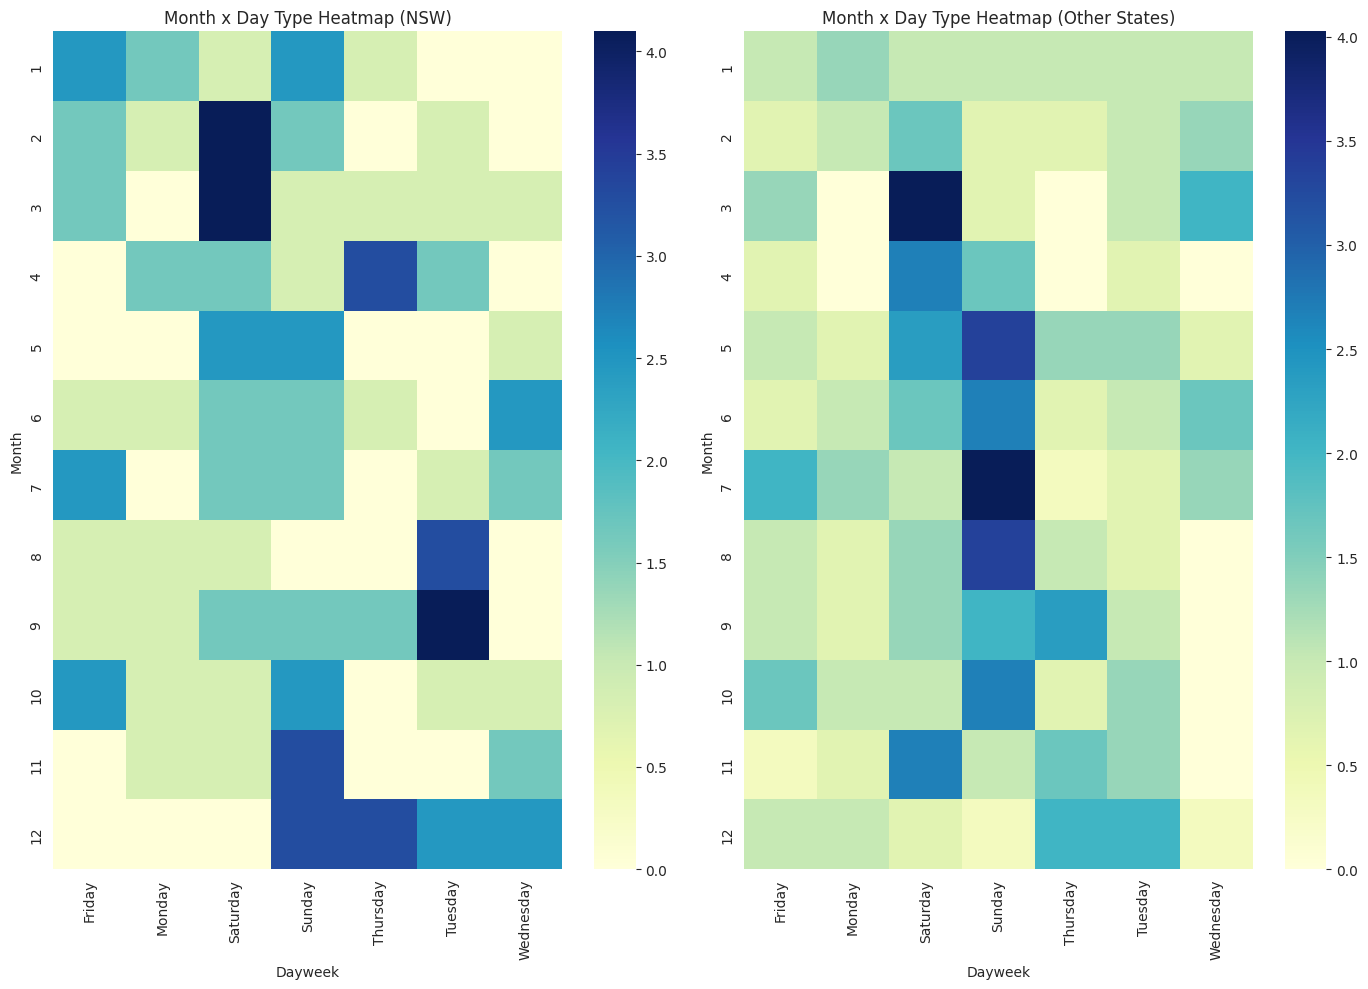

In [ ]:
# Month x Day Type (Weekday/Weekend) Heatmap

# Creating a new column 'Day Type' to categorize days as 'Weekday' or 'Weekend'

# Grouping the data by 'Month' and 'Day Type' for NSW
month_daytype_nsw = nsw_data.groupby(['Month', 'Dayweek']).size().unstack().fillna(0)
month_daytype_nsw_percentage = (month_daytype_nsw / month_daytype_nsw.sum().sum()) * 100

# Grouping the data by 'Month' and 'Day Type' for other states
month_daytype_non_nsw = non_nsw_data.groupby(['Month', 'Dayweek']).size().unstack().fillna(0)
month_daytype_non_nsw_percentage = (month_daytype_non_nsw / month_daytype_non_nsw.sum().sum()) * 100

# Creating heatmaps
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

sns.heatmap(month_daytype_nsw_percentage, cmap='YlGnBu', ax=ax[0])
ax[0].set_title('Month x Day Type Heatmap (NSW)')

sns.heatmap(month_daytype_non_nsw_percentage, cmap='YlGnBu', ax=ax[1])
ax[1].set_title('Month x Day Type Heatmap (Other States)')

plt.tight_layout()
plt.show()


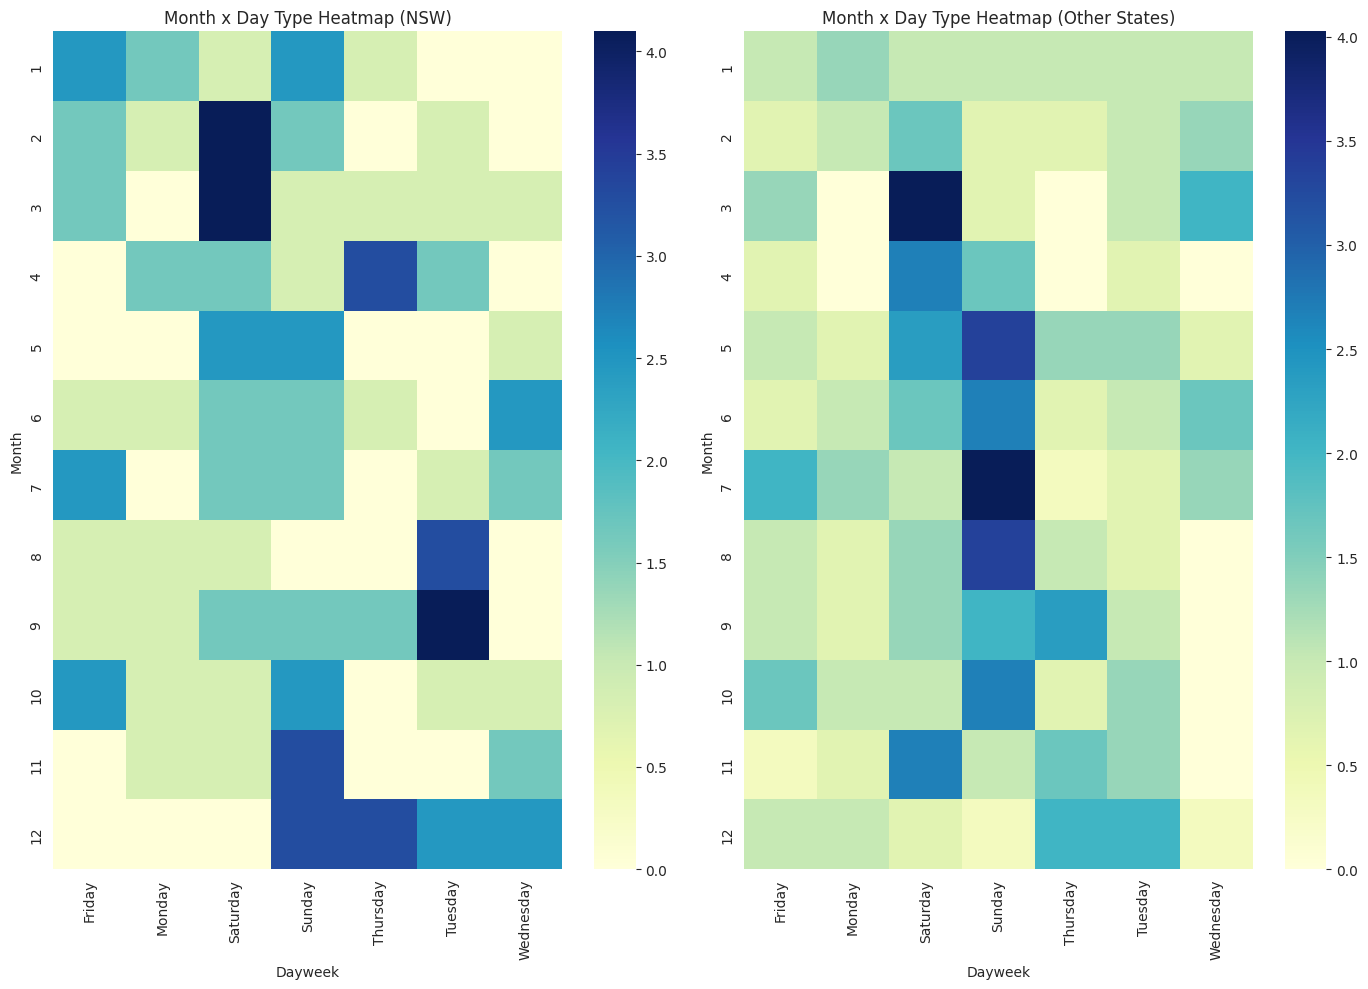

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10))



sns.heatmap(month_daytype_nsw_percentage, cmap='YlGnBu', ax=ax[0])
ax[0].set_title('Month x Day Type Heatmap (NSW)')

sns.heatmap(month_daytype_non_nsw_percentage, cmap='YlGnBu', ax=ax[1])
ax[1].set_title('Month x Day Type Heatmap (Other States)')

plt.tight_layout()
plt.show()